In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
import xgboost as xgb

In [218]:
df=pd.read_csv('data/Tweets.csv', encoding='latin1')

In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [220]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [221]:
df.dropna(subset=['tweet_text'], inplace=True)

In [222]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [223]:
def google_product_finder(x):
    google_pattern='[Gg]oogle\s[A-Za-z0-9]*'
    s=''
    product=re.findall(google_pattern, x)
    if product !=[]:
        s+=str(product).title()
        return s.replace('[', '').replace(']', '').replace("'", "")
    else:
        return np.nan

In [224]:
def i_product_finder(x):
    i_pattern='i[A-Z][A-Za-z0-9]*'
    s=''
    product=re.findall(i_pattern, x)
    if product !=[]:
        s=str(product).replace('[', '').replace(']', '').replace("'", "")
        return s
    else:
        return np.nan

In [225]:
def straggler_cleaner(x):
    x=x.lower()
    if 'google' in x and 'maps' in x:
        return 'Google Maps'
    elif 'google' in x and 'map' in x:
        return 'Google Maps'
    elif 'google' in x and 'photobooth' in x:
        return 'Google Photobooth'
    elif 'google' in x and 'route-around' in x:
        return 'Google Maps'
    elif 'google' in x and 'route around' in x:
        return 'Google Maps'
    elif 'google' in x and 'circles' in x:
        return 'Google Circles'
    elif "'circles'" in x:
        return 'Google Circles'
    elif 'google' in x:
        return 'Google'
    elif 'iphone charger' in x:
        return 'iPhone charger'
    elif 'itunes' in x:
        return 'iTunes'
    elif 'apple' and 'macs' in x:
        return 'Mac'
    elif 'apple' and 'mac' in x:
        return 'Mac'
    elif 'iphone' and 'case' in x:
        return 'iPhone case'
    elif 'ipad' in x:
        return 'iPad'
    elif 'iphone' in x:
        return 'iPhone'
    elif 'apple' in x:
        return 'Apple'
    elif 'android' in x:
        return 'Android'
    elif 'circles' in x:
        return 'Google Circles'
    elif 'sxsw' in x:
        return 'SXSW'
    else:
        return 'Other'

In [226]:
def product_cleaner(df):
    values_to_fix=['Other Google product or service', 'Other Apple product or service', '']
    functions=[google_product_finder, i_product_finder, straggler_cleaner]
    for v, f in zip(values_to_fix, functions):
        df.loc[df['emotion_in_tweet_is_directed_at']==v, 'emotion_in_tweet_is_directed_at']=df.loc[df['emotion_in_tweet_is_directed_at']==v]['tweet_text'].apply(f)
    for f in functions:
        df.loc[df['emotion_in_tweet_is_directed_at'].isna(), 'emotion_in_tweet_is_directed_at']=df.loc[df['emotion_in_tweet_is_directed_at'].isna()]['tweet_text'].apply(f)

In [227]:
#call the function to clean values in emotion_in_tweet_is_directed_at column
product_cleaner(df)

In [228]:
#fix function error
df.loc[df['emotion_in_tweet_is_directed_at']=='Google To', 'emotion_in_tweet_is_directed_at']='Google'

In [229]:
def unknown_character_replacer(x):
    unknown_characters='ÅÃÂ¡Å½ÃÃÅÃ¼â¹ÂÃâ¹ÂÃâ¹ÂÃâ¹ÂÂ£â]°°¢,'
    for u in unknown_characters: 
        x=x.replace(u, '')
    return x

In [230]:
df['tweet_text']=df['tweet_text'].apply(unknown_character_replacer)

In [231]:
df['positive_sentiment']=df['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 1 if x =='Positive emotion' else 0)
df['negative_sentiment']=df['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 1 if x =='Negative emotion' else 0)
sentiments=pd.concat([df.groupby('emotion_in_tweet_is_directed_at')['positive_sentiment'].sum().sort_values(ascending=False), df.groupby('emotion_in_tweet_is_directed_at')['negative_sentiment'].sum().sort_values(ascending=False)], axis=1, ignore_index=False)
top_8_sentiments=sentiments[:8]

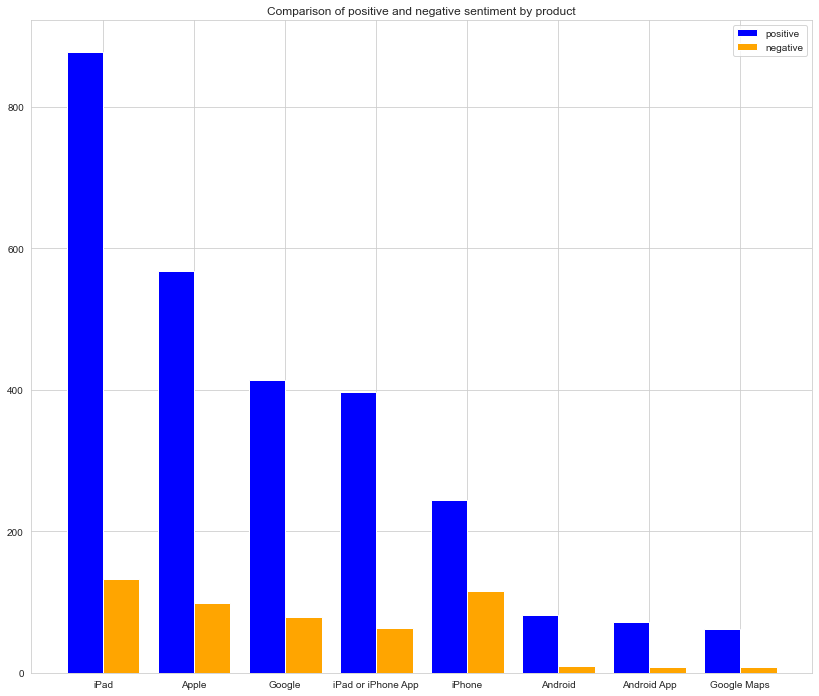

In [232]:
sns.set_style("whitegrid")
fig, ax=plt.subplots(figsize=(14,12))
width=0.4
ax.bar(np.arange(1,9,1)-width/2, top_8_sentiments['positive_sentiment'], width=width, color='blue', label='positive')
ax.bar(np.arange(1,9,1)+width/2, top_8_sentiments['negative_sentiment'], width=width, color='orange', label='negative')
ax.set_xticks(np.arange(1,9,1))
ax.set_xticklabels(top_8_sentiments.index)
ax.set_title('Comparison of positive and negative sentiment by product')
ax.legend();

#next step: clean tweets column

In [233]:
df['emotion_in_tweet_is_directed_at'].value_counts().head(13).values.sum()

7713

remove stopwords

WordNetLemmatizer

count vectorizer

In [234]:
lemmatizer=WordNetLemmatizer()
lemmatizer.lemmatize(df['tweet_text'].iloc[0])

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin it was dead!  I need to upgrade. Plugin stations at #SXSW.'

In [235]:
for t in df.loc[df['negative_sentiment']==1]['tweet_text']:
    print(t)

.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin it was dead!  I need to upgrade. Plugin stations at #SXSW.
@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw
I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone
@mention  - False Alarm: Google Circles Not Coming Nowand Probably Not Ever? - {link} #Google #Circles #Social #SXSW
Again? RT @mention Line at the Apple store is insane.. #sxsw
attending @mention iPad design headaches #sxsw {link}
Boooo! RT @mention Flipboard is developing an iPhone version not Android says @mention #sxsw
What !?!? @mention  #SXSW does not provide iPhone chargers?!?  I've changed my mind about going next year!
Know that &quot;dataviz&quot; translates to &quot;satanic&quot; on an iPhone. I'm just sayin'. #sxsw
Seriously #sxsw? Did you do any testing on the mobile apps? Constant iPad crashes causing lost schedules and no sync for WP7.
ip

In [236]:
sw=stopwords.words('english')

In [237]:
df['tweet_text'].iloc[0]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin it was dead!  I need to upgrade. Plugin stations at #SXSW.'

In [238]:
#[lemmatizer.lemmatize(w) for w in word_tokenize(df['tweet_text'].iloc[0])]

In [239]:
count_vectorizer=CountVectorizer(ngram_range=(1,1), stop_words='english')
X=count_vectorizer.fit_transform(df['tweet_text']).astype(np.int32).toarray()

In [240]:
vectorized_data=pd.concat([df.reset_index(drop=True), pd.DataFrame(data=X, columns=count_vectorizer.get_feature_names())], axis=1)

In [241]:
vectorized_data['is_there_an_emotion_directed_at_a_brand_or_product']=vectorized_data['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 'No emotion toward brand or product' if x=="I can't tell" else x)

In [242]:
le=LabelEncoder()
vectorized_data['emotion']=le.fit_transform(vectorized_data['is_there_an_emotion_directed_at_a_brand_or_product'])

In [243]:
vectorized_data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,positive_sentiment,negative_sentiment,00,00am,00pm,01am,02,...,zombie,zombies,zomg,zone,zoom,zuckerberg,zynga,zzzs,¾_¾,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [244]:
vectorized_X=vectorized_data[vectorized_data.columns[5:-1]]
vectorized_y=vectorized_data.emotion

In [245]:
X_train, X_test, y_train, y_test=train_test_split(vectorized_X, vectorized_y, random_state=42)

In [246]:
def model_tester(model, X_train=X_train, y_train=y_train):
    model.fit(X_train, y_train)
    return cross_val_score(model, X_train, y_train).mean()

In [247]:
logreg=LogisticRegression(C=0.1)
model_tester(logreg)

0.6851423137248996

In [248]:
bayes=MultinomialNB()
model_tester(bayes)

0.6584515784785587

In [249]:
dtc=DecisionTreeClassifier()
model_tester(dtc)

0.6239914110455846

In [250]:
rfc=RandomForestClassifier()
model_tester(rfc)

0.6844098213574937

In [251]:
#g=xgb.XGBClassifier()
#model_tester(xg)

In [252]:
le=LabelEncoder()
df['emotion']=le.fit_transform(df['is_there_an_emotion_directed_at_a_brand_or_product'])

In [253]:
pipeline=Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,2), stop_words='english')), ('logreg', LogisticRegression(C=0.1))])

In [254]:
X_tweet_train, X_tweet_test, y_tweet_train, y_tweet_test=train_test_split(df['tweet_text'], df['emotion'])

In [255]:
pipeline.fit(X_tweet_train, y_tweet_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('logreg', LogisticRegression(C=0.1))])

In [256]:
pipeline.score(X_tweet_test, y_tweet_test)

0.6717993840739112

In [257]:
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,positive_sentiment,negative_sentiment,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,0,1,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,1,0,3
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,1,0,3
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0,1,1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,1,0,3
...,...,...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,1,0,3
9089,Wave buzz... RT @mention We interrupt your reg...,Google,No emotion toward brand or product,0,0,2
9090,Google's Zeiger a physician never reported pot...,Google,No emotion toward brand or product,0,0,2
9091,Some Verizon iPhone customers complained their...,iPhone,No emotion toward brand or product,0,0,2


In [258]:
#gridsearch=GridSearchCV()

TypeError: __init__() missing 2 required positional arguments: 'estimator' and 'param_grid'